In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as ck

import utilities.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex

# data sources
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_gis.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",
    "dims_data":"dims_data.csv"
}

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-01-01'
end_date ='2021-04-30'
a_fail_rate = 50
# name of the output folder:
name_of_project = 'bassin_report_aare'

# set the maps
bassin_map = PILImage.open("resources/maps/aare_scaled.jpeg")
# city_map = PILImage.open("resources/maps/biel_scaled.jpeg")


feature_level = "river_bassin"
feature_component = "water_name_slug"
top = "All survey areas"
levels = {feature_component: "water_name_slug", feature_level:'aare', top:"All survey areas"}


level_names = ["Aare survey area","All survey areas"]

# levels = {"city":"Bern","water_name_slug":'aare', "river_bassin":'aare'}
# level_names = ["Linth survey area", "All survey areas"]
# feature_order = [
#     "limmat",
#     "zurichsee",
#     "katzensee",
#     "dorfbach",
#     "sihl", 
#     "Sihlsee",       
#     "jona",
#     "escherkanal",
#     "linthkanal",
#     "walensee",
#     "seez",
# ]

# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# define the methods to handle the data .JSON or .csv:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups, dfDims = sut.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)


# convenience methods


def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)

def get_feature_component(data, feature_level, feature_component):
    return data.loc[data[feature_level] == levels[feature_component]].copy()


def aggregate_a_group_of_codes(data, codes=[], groupby_column="", agg_columns={}):
    
    return data[data.code.isin(codes)].groupby(groupby_column, as_index=False).agg(agg_columns)

def replace_a_group_of_codes_with_one(data, new_code_values=[], codes_to_replace=[]):    
    
    som_data=data[~data.code.isin(codes_to_replace)].copy()
    new_data = pd.concat(new_code_values, ignore_index=True)
    return_data = pd.concat([som_data, new_data], ignore_index=True)
    
    return return_data

def agg_a_group_of_codes_with_one_code(data, new_values, a_list_loc_dates=[], a_model_code=" ", a_new_code=""):
    # aggregate and assign a new code for the values:
    new_df_rows = []
    new_vals = new_values.set_index('loc_date', drop=True)
    for adate in a_list_loc_dates:
        gx = data.loc[(data.loc_date == adate)&(data.code==a_model_code)].copy()        
        gx['code'] = a_new_code
        gx['quantity'] = new_vals.loc[[adate], 'quantity'][0]
        gx['pcs_m'] = new_vals.loc[[adate], 'pcs_m'][0]
        new_df_rows.append(gx)

    # create a data frame with the new values
    new_data = pd.concat(new_df_rows)
    
    return new_data, new_df_rows

def create_aggregate_groups(data, codes_to_agg=[], a_model_code="G79", a_new_code="Gfrags" ):
    
    agretd =  aggregate_a_group_of_codes(data, codes=codes_to_agg, groupby_column='loc_date', agg_columns={'quantity':'sum', 'pcs_m':'sum'})
    loc_dates = agretd.loc_date.unique()
    df, _ = agg_a_group_of_codes_with_one_code(data, agretd, a_list_loc_dates=loc_dates, a_model_code=a_model_code, a_new_code=a_new_code)    
    
    return df
# new column names for display
new_cols = {
    'total_time':'time to survey',
    'length':'meters surveyed',
    'area':'m² surveyed',
    'total_w':'total weight',
    'mac_plast_w':'plastic > 5mm weight',
    'mic_plas_w':'plastic < 5mm weight',
    'num_parts_staff':'staff',
    'num_parts_other':'help',
    'participants':'groups',
    'loc_date':'# samples'
}

# columns to aggregate dimensional data
agg_this = {
    'time to survey':'sum',
    'meters surveyed':'sum',
    'm² surveyed':'sum',
    'total weight':'sum',
    'plastic > 5mm weight':'sum',
    'plastic < 5mm weight':'sum',
    'staff':'sum',
    'help':'sum',
    '# samples':'nunique'
}

def make_a_summary_table(ax, data, cols_to_use, a_color='dodgerblue', font_size=12, s_et_bottom_row=True):
    
    
    ax.auto_set_font_size(False)
    the_cells = ax.get_celld()    
    
    banded_color = colors.to_rgba(a_color)
    banded_color= (*banded_color[:-1], 0.1)
    
    
    # the different areas of formatting
    top_row = [(0,i) for i,x in enumerate(cols_to_use)]
    bottom_row =[(len(data), i) for i,x in enumerate(cols_to_use) ]
    top_columns = top_row[1:]
    data_rows = [x for x in list(the_cells.keys()) if x not in top_row]
    odd_rows = [x for x in data_rows if x[0]%2 > 0]
    first_column = [x for x in data_rows if x[1] == 0]
    
    
    # make the first cell a littel smaller than the others
    ax[0,0].set_height(1/(len(data)))
    ax[0,0].set_text_props(**{'va':'top'})
   
    for a_cell in top_row:
        ax[a_cell].visible_edges = 'B'    
        ax[a_cell].set_text_props(**{'fontsize':font_size})
        ax[a_cell].set_edgecolor('white')
        ax[a_cell].PAD = .1        
       
    for a_cell in top_columns:
        ax[a_cell].set_height((1.25/(len(data))))
        ax[a_cell].set_text_props(**{'va':'bottom'})
        ax[a_cell].set_edgecolor(banded_color)
        ax[a_cell].visible_edges = 'T'    
    
    for a_cell in odd_rows:
        ax[a_cell].set_facecolor( banded_color)
    
    for a_cell in data_rows:
        ax[a_cell].set_height(.75/(len(data)))
        ax[a_cell].visible_edges = 'BTLR' 
        ax[a_cell].set_text_props(**{'fontsize':font_size})
        ax[a_cell].set_edgecolor('white')
        
    for a_cell in first_column:
        ax[a_cell]._text.set_horizontalalignment('right')
        ax[a_cell].PAD = .02
    if s_et_bottom_row == True:        
        for a_cell in bottom_row:
            ax[a_cell].visible_edges = 'B'
            ax[a_cell].set_edgecolor(banded_color) 
        
        
    return ax

def add_a_new_code(a_name, a_model, a_dict_params, code_df):
    
    for param in a_dict_params:
        a_model[param] = a_dict_params[param]
    
    code_df.loc[a_name] = a_model
    
    return code_df
def shorten_the_value(an_array,a_df):
    a_df.loc[an_array[0], an_array[1]] = an_array[2]
    return a_df
# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# Create new codes to aggregate the EPS pieces and the Plastic pieces
a_name = 'Gfrags'
a_model = dfCodes.loc['G79'].copy()
a_dict_params = {'description':'Fragmented plastics'}

dfCodes = add_a_new_code(a_name, a_model, a_dict_params, dfCodes)

a_name = 'Gfoam'
a_model = dfCodes.loc['G82'].copy()
a_dict_params = {'description':'Expanded polystyrene'}

dfCodes = add_a_new_code(a_name, a_model, a_dict_params, dfCodes)

# these descriptions need to be shortened for display
dfCodes = shorten_the_value(["G74", "description", "Insulation: includes spray foams and foam board"], dfCodes)
dfCodes = shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = shorten_the_value(["G96", "description", "Sanitary-pads/panty liners/tampons"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material


<a id='top'></a>
## Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQASL)

IQAASL is a project sponsored by the Swiss Federal Office for the Environment to quantify shoreline trash along swiss lakes and rivers. Multiple small scale **litter surveys** are completed at different locations within a designated survey area. For the year 2020/2021 the survey areas were defined by the municipalities that border the Aare, Rhône, Ticino and Linth/Limmat rivers and any lakes or rivers that contribute to one of these rivers.

### What is a litter survey?

A litter survey is the **identification and count of all anthropogenic objects found within a delimited area**, in this study all surveys were bordered on one side by water (a river or lake). Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted. 

#### Purpose of the surveys

The survey results help ALL stakeholders identify the items that make up the mass of trash found in the natural environment and where those objects are most likely to be found. The surveys answer the following questions:

*  What items are found?
   * The most abundant objects from the water feature and the survey area sorted by total object count 
*  How much is found ? (total weights and item counts)
   * Total object count, total weight and weight of plastics
*  How often are these items found?
   * How often the most abundant items were identified
*  Where do you find the most?
   * Pieces of trash per meter (pcs/m): the ratio of number of objects found to the length of the shoreline for each survey location

These are the most frequently asked questions and should be considered when determining any mitigation or reduction strategies.

#### Assumptions:

*  The more trash there is on the ground the more a person is likely to find
*  The survey results represent the minimum amount of trash at that site²
*  For each survey: finding one item does not effect the chance of finding another³

#### Purpose of this report

Summarize the results for the water feature and define the magnitude of those results with respect to the rest of the survey area. 

#### Contents of this report

[Scope: description of water feature](#scope)
  * survey locations
  * lakes and rivers
  * municipalities and effected population
   
[Survey dimensions: locations, aggregated totals](#aggregatedtotals)
  * weights and measures: cumulative
  * weights and measures: cumulative by survey location
  * survey totals by location: pcs/m by date
  * material type: % of total
   
[Trash removed: the most abundant objects](#combinedtopten)
  * the most common objects from the survey area
  * the most common objects from all the survey areas
  * pcs/m of the most common objects for all water features
   
[Trash removed: the most frequent](#frequency)
  * The rate at which the most frequent objects were identified
  
[Trash removed: utility](#matanduse)
  * utility classification: % total of all objects found

[Annex](#annex)
  * effective data: report of missing records  
  * correlation of results to local conditions
  * survey location coordinates
  * itemized list of objects removed

### More information

For more information about the project visit [project home](https://www.plagespropres.ch/).

If you would like more information about this survey area please contact:

1. Swiss federal office for the environment - Municipal waste section
2. analyst@hammerdirt.ch

¹ [The EU guide on monitoring marine litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)<br> ² There is most likely more trash at the survey site, but certainly not less than what was recorded.<br>³ Independent observations : [stats stackexchange](https://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean)

In [2]:
md(F"## Results: {level_names[0]}")

## Results: Aare survey area

### <a id="scope"></a>Scope

The Aare source is the Aare Glaciers in the Bernese Alps of south-central Switzerland. The Aare is the longest river entirely within Switzerland with a length of 295 km and drainage area of 17,779 km2. Following the Aare Gorge, the river expands into the glacial Lake Brienz. The Aare is canalized at Interlaken before entering Lake Thun and exiting through the city of Thun.⁵ The river then flows northwest surrounding the old city center of Bern on three sides. Continuing west to Lake Wohlen Reservoir it turns north to Aarberg and is diverted west into Lake Biel by the Hagneck Canal, one of a series of major water corrections made in the 19th and 20th centuries connecting Neuchatel, Biel and Morat lakes through canalization. From the upper end of Lake Biel, at Nidau, the river exits through the Nidau-Büren Canal/Aare Canal.⁶

The Limmat and Reuss rivers⁷, two major tributaries converge into the Aare at the Limmatspitz between the cities of Brugg and Untersiggenthal in Canton Aargau.⁸ The Aare river ends in the north-western region of Koblenz, Switzerland where it joins the Rhine river which eventually terminates in the North Sea.

<span style="font-size:10px">⁵ The Editors of Encyclopaedia Britannica. (1998, July 20). Aare River. Retrieved from Britannica.com: https://www.britannica.com/place/Aare-River 
<br>⁶ Standard Encyclopedia of Worlds Rivers and Lakes. (1965) R.K. Gresswell
<br>⁷ The Limmat and Reuss are part of different survey areas
<br>⁸ Pro Natura . (n.d.). Limmatspitz. Retrieved from Pro Natura : https://www.pronatura-ag.ch/de/Gebenstorf-limmatspitz</span>


#### Survey locations, municipalities


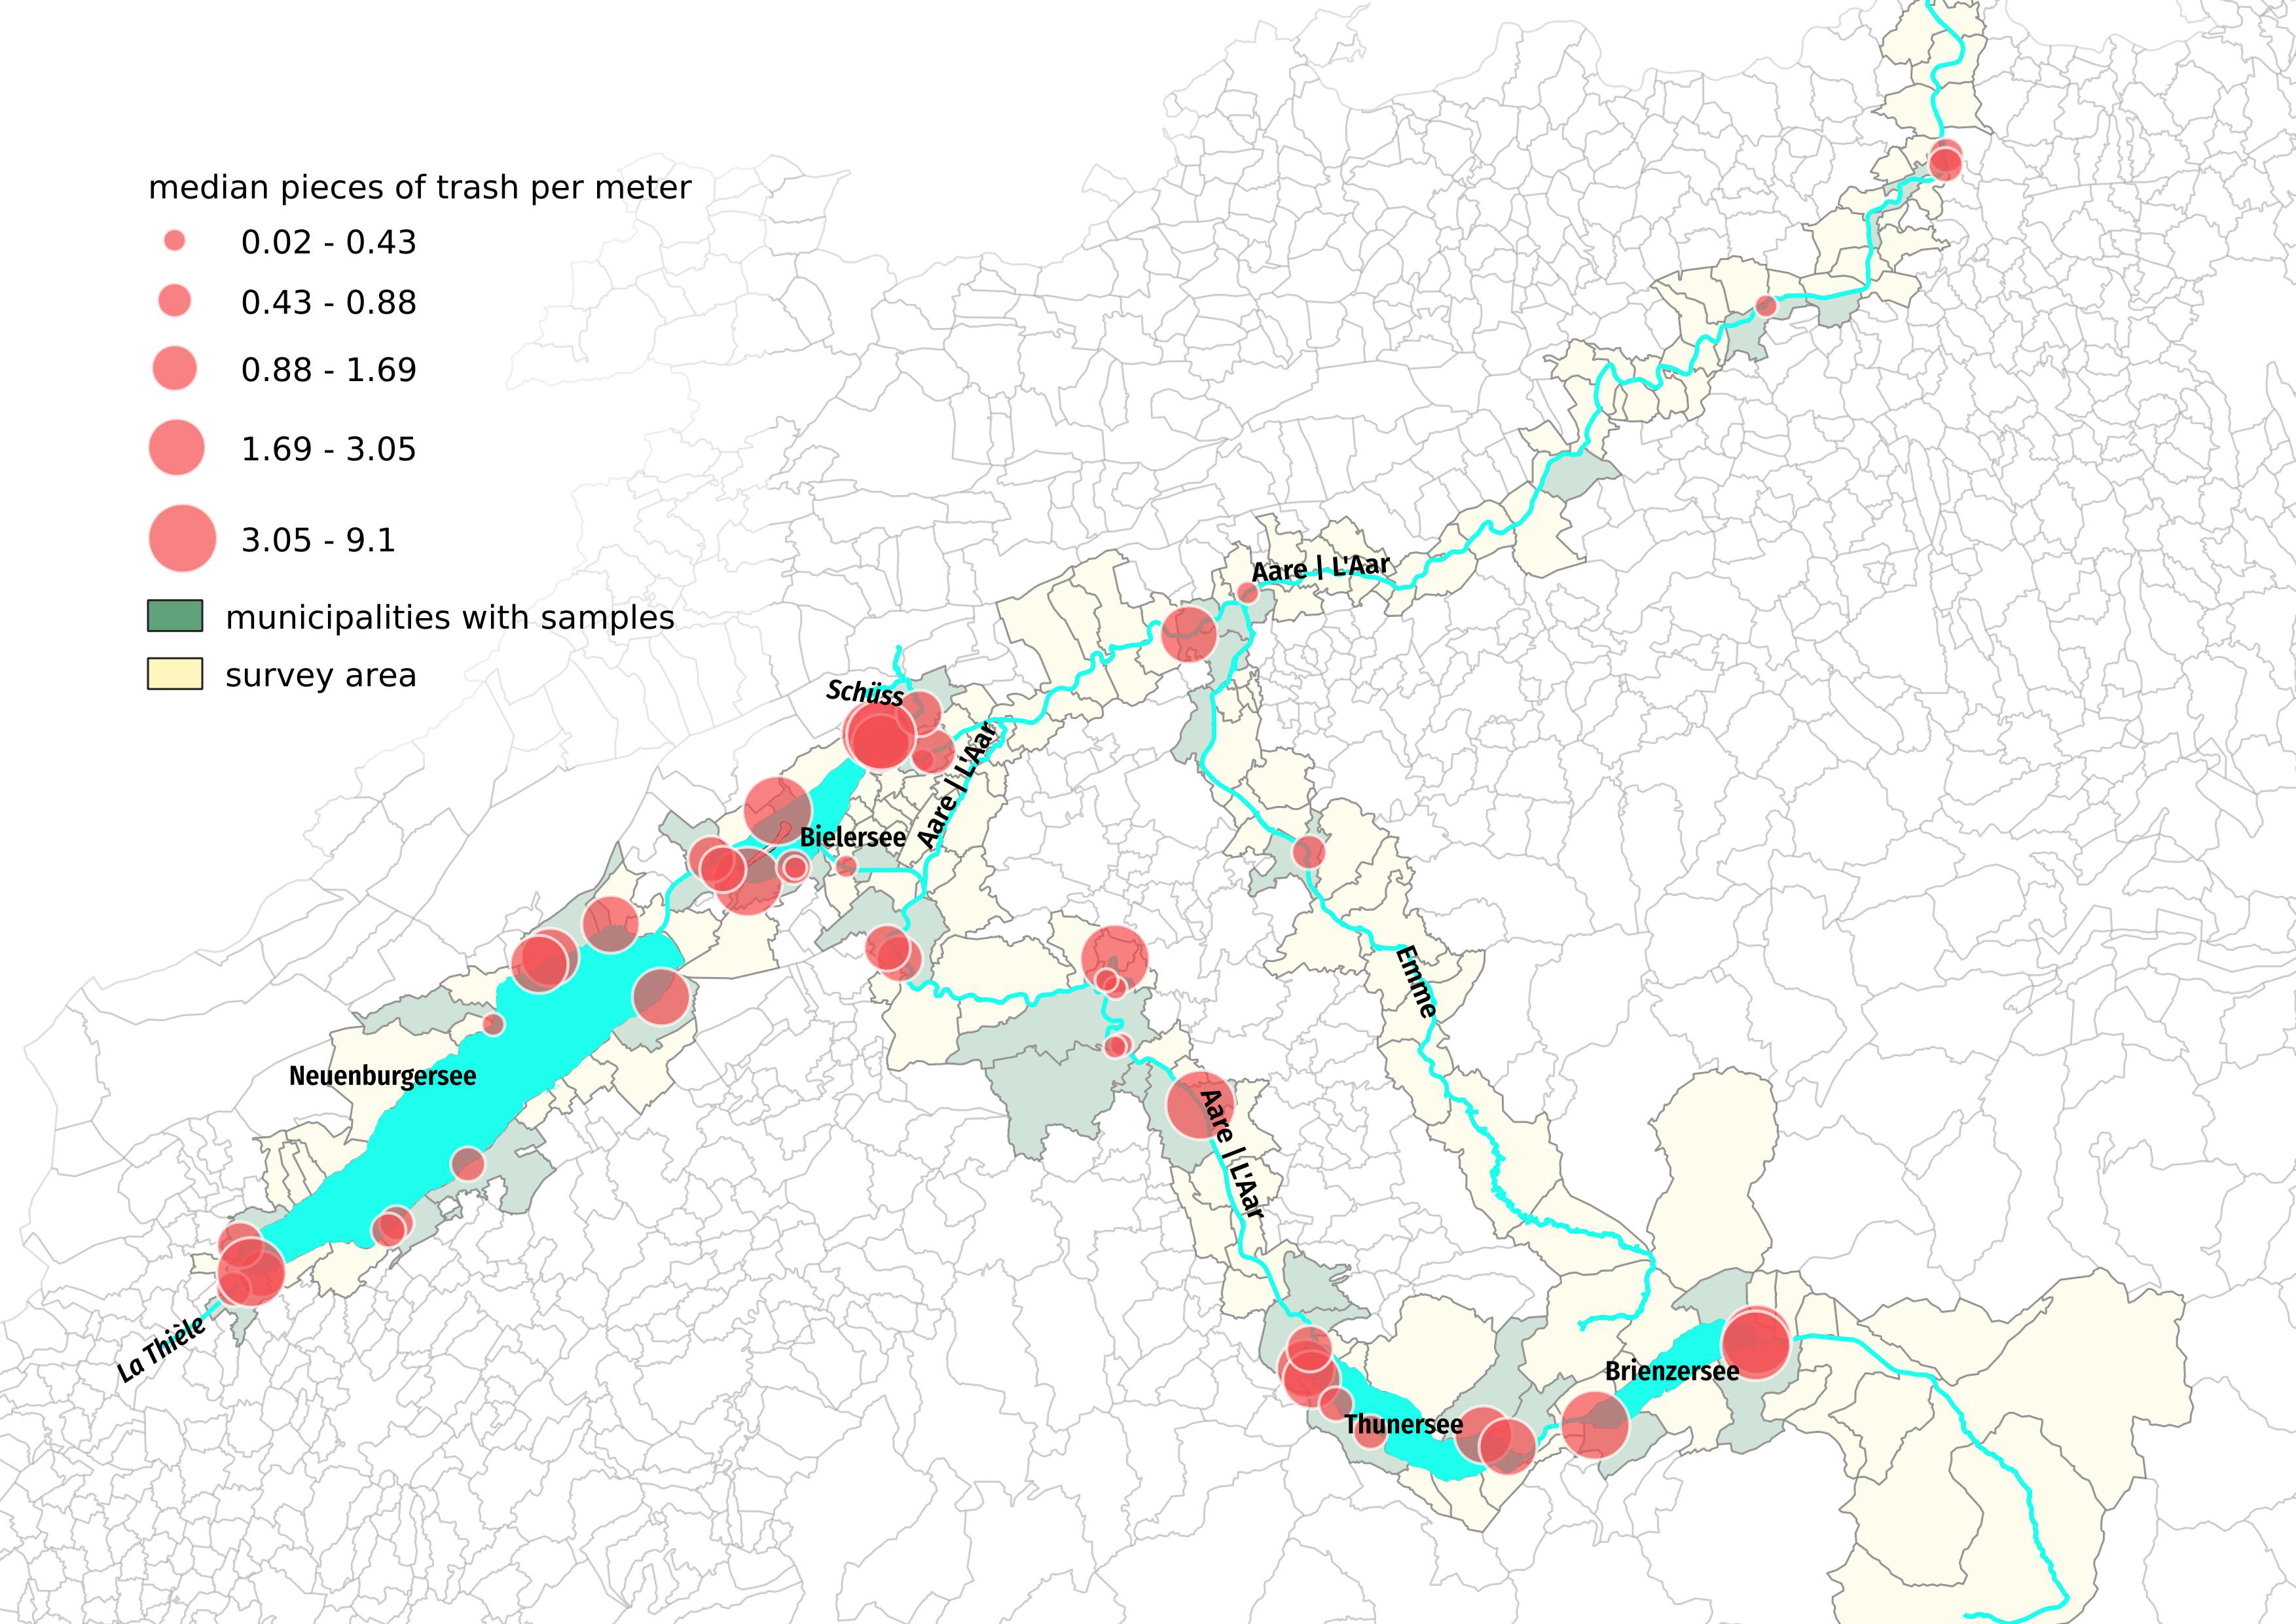

In [3]:
output = io.BytesIO()
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

In [4]:
# format the date to timestamp and slice the data by start/end date
dfSurveys = sut.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# siblings = river_bassins[levels[top]]


# add the grouping column defined by river_bassins
data = sut.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")
# data = data.loc[data.river_bassin == levels[top]]

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = sut.SurveyData(data, dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())
    
the_plast_rows = create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
new_som_data = replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# keep the orginal data to test on
before_agg = a_data.copy()

# replace a_data with new new_som_data
a_data = new_som_data.copy()

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# map material to a_data
a_data['material'] = a_data.code.map(lambda x: code_material_map[x])

# get the material totals
material_totals = a_data.groupby('material').quantity.sum()

code_totals_all_data = a_data.groupby('code', as_index=False).quantity.sum()

# all data top ten
ct_all_data = code_totals_all_data[['code','quantity']].sort_values(by='quantity', ascending=False)

# percent of total
ct_all_data["% of total"] = ct_all_data.quantity/ct_all_data.quantity.sum()
ct_all_data.set_index('code', inplace=True)
ct_all_data['material'] = ct_all_data.index.map(lambda x: code_material_map[x])
dt_all = a_data.groupby(['loc_date', 'date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

if levels[top] == "All survey areas":
    top_feature_data = a_data.copy()
else:
    top_feature_data = a_data[a_data[top] == levels[top]].copy()
    
tp_feat_dt = top_feature_data.groupby(['loc_date', 'date'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

fail_rates_top = ac.agg_fail_rate_by_city_feature_basin_all(top_feature_data, {'water_name_slug': 'water_name_slug', 'river_bassin': 'aare'}, group='code')


tp_ct = top_feature_data.groupby("code", as_index=False).quantity.sum()
tp_ct["% of total"] = tp_ct.quantity/tp_ct.quantity.sum()
tp_ct.set_index('code', inplace=True)
tp_ct.sort_values(by='quantity', inplace=True, ascending=False)

In [5]:
# define the data set for the feature level:
fd = a_data.loc[a_data[feature_level] == levels[feature_level]].copy()

# get the unique loc_date values:
fd_samps = list(fd.loc_date.unique())

# gather the survey location names:
fd_locs = list(fd.location.unique())

# gather the feature component names and types for the basin
fc_names = list(fd[feature_component].unique())

In [6]:
# feature_type_map = dfBeaches.loc[dfBeaches.water_name_slug.isin(fc_names)][[feature_component, 'water']].drop_duplicates().set_index(feature_component, drop=True)
# rb_rivers = list(feature_type_map.loc[feature_type_map.water == 'r'].index)
# rb_lakes = list(feature_type_map.loc[feature_type_map.water == 'l'].index)

# gather the municpalities and the population:
fd_munis = list(fd.city.unique())
fd_pop_map=fd.loc[fd.city.isin(fd_munis)][['city', 'population']].drop_duplicates().set_index('city', drop=True)

# survey_totals river bassin
fd_dt=fd.groupby(['loc_date', 'date',feature_component], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})

# map survey total quantity to loc_date
fd_dq = fd_dt[['loc_date', 'quantity']].set_index('loc_date')

# map utility to code
utility_map = fd[['code', 'groupname']].drop_duplicates().set_index('code', drop=True)

# code totals for the river bassin
fd_code_t= fd.groupby('code', as_index=False).agg({'quantity':'sum', 'fail':'sum'})

# percent of total
fd_code_t["% of total"] = fd_code_t.quantity/fd_code_t.quantity.sum()
fd_code_t.set_index('code', inplace=True)
fd_code_t.sort_values(by='quantity', ascending=False, inplace=True)
fd_code_t['material'] = fd_code_t.index.map(lambda x: code_material_map[x])

# combined top ten all data and river bassin data
a_combined_t_ten = [*tp_ct.index[:10],*fd_code_t.index[:10]]

# material totals:
fd_mat_t = fd_code_t[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# map the number of samples per feature component
fd_samples_feature = fd.groupby(feature_component).loc_date.nunique()

# map total quantity per feature_component:
qty_all_features = fd.groupby(feature_component).quantity.sum()

qty_feature = {wname_wname.loc[x][0]:qty_all_features[x] for x in qty_all_features.index}

# get groupname totals
fd_group_totals = fd[fd.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
fd_group_totals = fd.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

# summary statistics:
fd_n_samps = len(fd_samps)
fd_n_obj = fd.quantity.sum()
fd_n_locs = len(fd_locs)
fd_n_munis = len(fd_munis)
fd_effected_population = fd_pop_map.sum()

In [7]:
# gather the dimensional data for the time frame from dfDims
fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()

# make a loc_date column and get the unique values
fd_dims['loc_date'] = list(zip(fd_dims.location, fd_dims.date))
dim_samps = list(fd_dims.loc_date.unique())

# map quantity per survey to the dims data
fd_dims['quantity'] = fd_dims.loc_date.map(lambda x: ut.use_this_key(x,fd_dq, column='quantity'))

# keep the dims that did not get tagged with a qty
no_qty = fd_dims[fd_dims.quantity == 'no data']

# drop the dims that did not match
som_dims = fd_dims[fd_dims.quantity != 'no data'].copy()

# identify the surveys with no matching dimensional data
no_matching_dim_records = [x for x in list(fd_samps) if x not in list(dim_samps)]

obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

In [8]:
date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}."
md(F"{date_quantity_context} {geo_context } {admin_context}")

For the period between 2020-01 and 2021-04, 13,858 objects were removed and identified in the course of 138 surveys. Those surveys were conducted at 49 different locations. There are 34 different municipalities represented in these results with a combined population of approximately 492,414.

In [9]:
fd_beaches_df = dfBeaches.loc[fd_locs].copy()
lakes = fd_beaches_df[fd_beaches_df.water == 'l']['water_name'].unique()
rivers = fd_beaches_df[fd_beaches_df.water == 'r']['water_name'].unique()

In [10]:
munis_joined = ', '.join(sorted(fd_munis))

muni_string = F"""**The municipalities in this report:**\n\n{munis_joined}
"""
md(muni_string)

**The municipalities in this report:**

Aarau, Beatenberg, Bern, Biel/Bienne, Boudry, Brienz (BE), Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Estavayer, Gals, Gebenstorf, Grandson, Hauterive (NE), Kallnach, Köniz, Le Landeron, Ligerz, Luterbach, Lüscherz, Neuchâtel, Nidau, Port, Rubigen, Solothurn, Spiez, Thun, Unterseen, Vinelz, Walperswil, Yverdon-les-Bains


In [11]:
lakes_joined = ', '.join(sorted(lakes))

lake_string = F"""**The lakes in this report:**\n\n{lakes_joined}
"""
md(lake_string)

**The lakes in this report:**

Bielersee, Brienzersee, Neuenburgersee, Thunersee


In [12]:
rivers_joined = ', '.join(sorted(rivers))

river_string = F"""**The rivers in this report:**\n\n{rivers_joined}
"""
md(river_string)

**The rivers in this report:**

Aare, Aare|Nidau-Büren-Kanal, Emme, La Thièle, Schüss


In [13]:
# assign a water feature name to each record
som_dims['water_name_slug'] = som_dims.location.map(lambda x: location_wname_key.loc[x])

# 90-120 minutes covers some of the travel, equipment preparation and maintenance and incidental time on location:
som_dims['total_time'] = ((som_dims.time_minutes+90)/60).round(2)

# rename the columns for display and export:
som_dims.rename(columns=new_cols, inplace=True)

dims_summary_stats = som_dims.groupby('water_name_slug').agg(agg_this)

# convert the plastic weights to kilos
dims_summary_stats['plastic > 5mm weight'] = dims_summary_stats['plastic > 5mm weight']/1000
dims_summary_stats['plastic < 5mm weight'] = dims_summary_stats['plastic < 5mm weight']/1000

# labor hours = (staff+help/number of samples)*time_to_survey
dims_summary_stats['labor hours'] = ((dims_summary_stats.staff + dims_summary_stats.help)/dims_summary_stats["# samples"])*dims_summary_stats['time to survey']
dims_summary_stats['labor hours'] = dims_summary_stats.astype('int')

# get the quantity found per water feature
dims_summary_stats['feature'] = dims_summary_stats.index.map(lambda x: wname_wname.loc[x][0])
dims_summary_stats.set_index('feature', inplace=True)
dims_summary_stats['pieces of trash'] = dims_summary_stats.index.map(lambda x: ut.use_this_key(x, qty_feature))

[top](#top)<a id="aggregatedtotals"></a>
### Survey  dimensions, location and aggregated totals.

In [14]:
# these columns should be ints
ints =  [
    'meters surveyed',
    'm² surveyed',
    'total weight',
    '# samples',
    'pieces of trash'
]

# columns to aggregate
col_order = ['# samples', 'pieces of trash',  'meters surveyed', 'm² surveyed', 'total weight', 'plastic > 5mm weight','plastic < 5mm weight', 'labor hours']

# aggregate the water feature frame
dims_stats = dims_summary_stats[col_order].sum().round(2)
dims_stats['# samples'] = len(som_dims)

# make a df for display or export
asum = pd.DataFrame(dims_stats).reset_index()
asum['summary total'] = level_names[0]
asum = asum.pivot(columns='index', values=0, index='summary total')
asum[ints] = asum[ints].applymap(lambda x: '{:,}'.format(int(x)))
asum = asum[col_order]

cum_results = F"#### Cumulative totals all data\nThe cumulative results from {fd_n_samps} samples, **weights are in kilograms, time is in hours**"
md(cum_results)

#### Cumulative totals all data
The cumulative results from 138 samples, **weights are in kilograms, time is in hours**

In [15]:
asum

index            # samples pieces of trash meters surveyed m² surveyed  \
summary total                                                            
Aare survey area       139          13,858           7,900      36,361   

index            total weight  plastic > 5mm weight  plastic < 5mm weight  \
summary total                                                               
Aare survey area           72                 31.43                  0.17   

index             labor hours  
summary total                  
Aare survey area        484.0

#### Cumulative totals by water feature

In [16]:
dims_summary_stats_display = dims_summary_stats.copy()
dims_summary_stats_display[ints] = dims_summary_stats_display[ints].applymap(lambda x: '{:,}'.format(int(x)))
dims_summary_stats_display[col_order]

# samples pieces of trash meters surveyed m² surveyed  \
feature                                                                        
Aare                          14             447             607       2,687   
Aare|Nidau-Büren-Kanal         2              56             106         565   
Bielersee                     39           4,618           1,281       6,228   
Brienzersee                    5             974             230       1,143   
Emme                           1              41              45         405   
La Thièle                      1               9              19          13   
Neuenburgersee                44           4,825           3,354      15,426   
Schüss                         2              98              92         381   
Thunersee                     31           2,790           2,166       9,513   

                       total weight  plastic > 5mm weight  \
feature                                                     
Aare                             13               5.85550   
Aare|Nidau-Büren-Kanal            1               0.13000   
Bielersee                        13               6.79000   
Brienzersee                       2               1.97212   
Emme                              2               1.13000   
La Thièle                         0               0.00100   
Neuenburgersee                   17               9.45100   
Schüss                            0               0.21000   
Thunersee                        19               5.89155   

                        plastic < 5mm weight  labor hours  
feature                                                    
Aare                                0.000170           39  
Aare|Nidau-Büren-Kanal              0.000024            5  
Bielersee                           0.003111          138  
Brienzersee                         0.160835           18  
Emme                                0.000000            5  
La Thièle                           0.000000            2  
Neuenburgersee                      0.003102          162  
Schüss                              0.000000            6  
Thunersee                           0.000359          109

#### Survey totals pieces per meter, material type % of total

In [17]:
# the monthly average
tp_feat_dt['month'] = tp_feat_dt.date.dt.month
dts_date = tp_feat_dt.set_index('date')
monthly_plot = dts_date.pcs_m.resample('M').median()

# material totals
fd_mat_totals = fd_mat_t.sort_values(by='quantity', ascending=False)

cols_to_use = {'material':'Item','quantity':'Quantity', '% of total':'% of total'}
fd_mat_totals['% of total'] =(fd_mat_totals['% of total']*100).round(1)
fd_mat_totals['quantity']=fd_mat_totals.quantity.map(lambda x: '{:,}'.format(x))
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

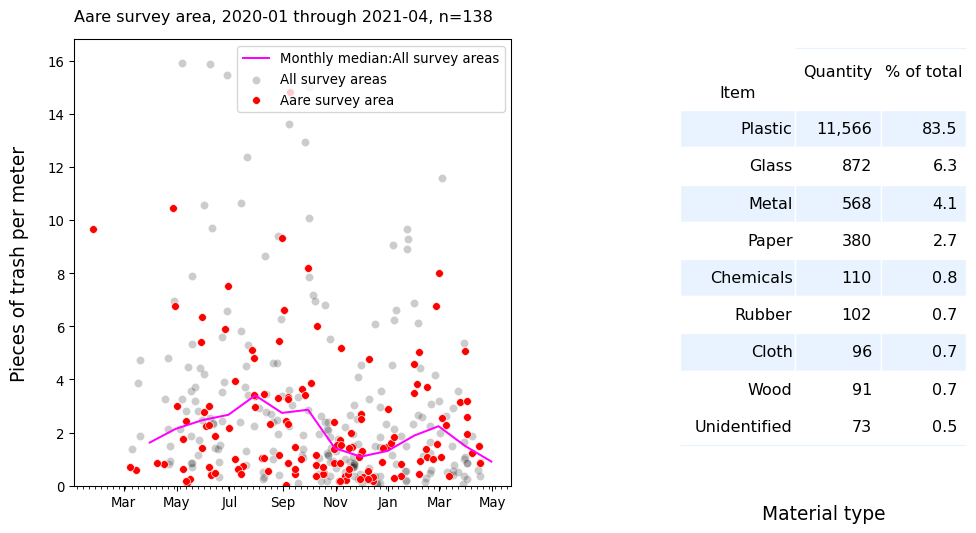

In [18]:
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

fig = plt.figure(figsize=(12,6), dpi=96)
gs = GridSpec(1, 12, figure=fig, wspace=.3, hspace=.3, top=.9)

axone = fig.add_subplot(gs[:, :6])
axtwo = fig.add_subplot(gs[:, 8:12])

def hide_spines_ticks_grids(an_ax):
    for spine in an_ax.spines.values():
        spine.set_visible(False)
    an_ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
    an_ax.grid(False)

hide_spines_ticks_grids(axtwo)
axtwo.set_xlabel("Material type", **ck.xlab_k14)
# all the data for the period
sns.scatterplot(data=dt_all, x='date', y='pcs_m', color='black', alpha=0.2, label="All survey areas", ax=axone)

# check the feature level and the top level:
if top == "All survey areas":
    sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color='magenta', label=F"Monthly median:{level_names[1]}", ax=axone)
    sns.scatterplot(data=fd_dt, x='date', y='pcs_m', color='red', s=34, ec='white',label=level_names[0], ax=axone)

else:
    sns.scatterplot(data=tp_feat_dt, x='date', y='pcs_m', color='black', alpha=0.4, label=level_names[1], ax=axone)    
    sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color='magenta', label=F"Monthly median:{level_names[1]}", ax=axone)
    sns.scatterplot(data=fd_dt, x='date', y='pcs_m', color='red', s=34, ec='white',label=level_names[0], ax=axone)

axone.set_xlabel("")
axone.set_ylabel("Pieces of trash per meter", **ck.xlab_k14)
axone.set_title(F"{level_names[0]}, {start_date[:7]} through {end_date[:7]}, n={fd_n_samps}",  **ck.title_k)
axone.xaxis.set_minor_locator(days)
axone.xaxis.set_major_formatter(months_fmt)
axone.set_ylim(0,fd_dt.pcs_m.max()+2)

a_table = axtwo.table(cellText=fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3], loc='upper center')
the_material_table_data = make_a_summary_table(a_table,fd_mat_totals,list(cols_to_use.values()))

plt.show()
plt.close()

[top](#top)<a id='combinedtopten'></a>
### The most abundant objects

In [19]:
# feature level top ten
rbt = fd_code_t[:10].copy()
rbt['item'] = rbt.index.map(lambda x: code_description_map.loc[x])

rbt['% of total'] =(rbt['% of total']*100).round(1)

rb_t_ten_total = rbt.quantity.sum()
rb_t_ten_ptotal = rb_t_ten_total/fd_code_t.quantity.sum()

rbt['quantity'] = rbt.quantity.map(lambda x: '{:,}'.format(x))


rb_string = F"Combined, the ten most abundant objects found in the {level_names[0]} represent {int(rb_t_ten_ptotal*100)}% of all objects found."
md(rb_string)

Combined, the ten most abundant objects found in the Aare survey area represent 65% of all objects found.

In [20]:
# river bassin top ten
adt = ct_all_data.sort_values(by='quantity', ascending=False)[:10].copy()
adt['item'] = adt.index.map(lambda x: code_description_map.loc[x])

adt['% of total'] =(adt['% of total']*100).round(1)

ad_t_ten_total = adt.quantity.sum()
ad_t_ten_ptotal = ad_t_ten_total/ct_all_data.quantity.sum()

adt['quantity'] = adt.quantity.map(lambda x: '{:,}'.format(x))

cols_to_use = {'item':'Item','quantity':'Quantity', '% of total':'% of total'}
all_survey_areas = adt[cols_to_use.keys()].values
rb_t_ten_d = rbt[cols_to_use.keys()].values

shared_objects = list(set(rbt.item) & set(adt.item))

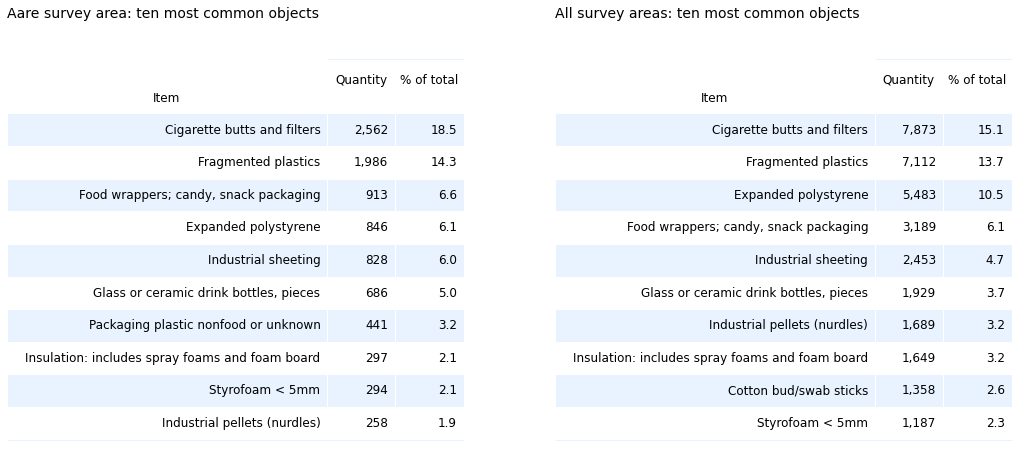

In [21]:
width = 18
a_color='dodgerblue'

fig, axs = plt.subplots(1,2, figsize=(width,len(rb_t_ten_d)*.8))
hide_spines_ticks_grids(axs[0])
hide_spines_ticks_grids(axs[1])

axs[0].set_title(F"{level_names[0]}: ten most common objects", **ck.title_k14)

axs[1].set_title(F"{level_names[1]}: ten most common objects", **ck.title_k14)

the_first_table_data = axs[0].table(rb_t_ten_d,  colLabels=list(cols_to_use.values()), colWidths=[.7, .15,.15],loc='center')
the_second_table_data = axs[1].table(all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.7, .15,.15],loc='center')

a_summary_table_one = make_a_summary_table(the_first_table_data,rbt,list(cols_to_use.values()), a_color)
a_summary_table_two = make_a_summary_table(the_second_table_data,adt,list(cols_to_use.values()), a_color)


plt.show()
plt.tight_layout()
plt.close()

In [22]:
ad_string = F"Of the most abundant objects in the {level_names[0]}, {len(shared_objects)} are also among the most abundant in {level_names[1]}."
the_shared_objects = [F"{i+1}. {x}" for i,x in enumerate(shared_objects)]
tso_string = '\n'.join(the_shared_objects)
md(F"{ad_string }\n{tso_string}")

Of the most abundant objects in the Aare survey area, 9 are also among the most abundant in All survey areas.
1. Industrial pellets (nurdles)
2. Expanded polystyrene
3. Insulation: includes spray foams and foam board
4. Cigarette butts and filters
5. Fragmented plastics
6. Styrofoam < 5mm
7. Industrial sheeting
8. Food wrappers; candy, snack packaging
9. Glass or ceramic drink bottles, pieces


#### The most abundant objects: results by water feature

Some objects are found throughout the survey area and some of those objects are found in all survey areas. Knowing which objects are most abundant and what those values are helps idenitify sources or zones of accumulation. 

In [23]:
# the feature component
feature_names = [wname_wname.loc[x][0] for x in fc_names]

# the names/labels to search with:
# column_names = [*feature_names, levels[feature_level]]

fc_names_dict = {levels[feature_component]:[x for x in fc_names]}
feature_name_dict = {feature_level:[levels[feature_level]]}


features_and_levels = {**fc_names_dict, **feature_name_dict}


# the names labels to display
names_for_cols = [*feature_names,*level_names[:1]]


In [24]:
#kwargs for aggregator
these_kwargs = dict(
    group='code',
    dailycols={'pcs_m':'sum', 'quantity':'sum'}, 
    agg_cols={"pcs_m":"mean"},
    national=True,
    col_name="All survey areas",
    level_names=names_for_cols,
    bassin_summary=True,
    daily=True,
    feature_component=feature_component,
    feature_level=feature_level
)

t_ten_all_data = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(a_combined_t_ten))], features_and_levels, **these_kwargs)

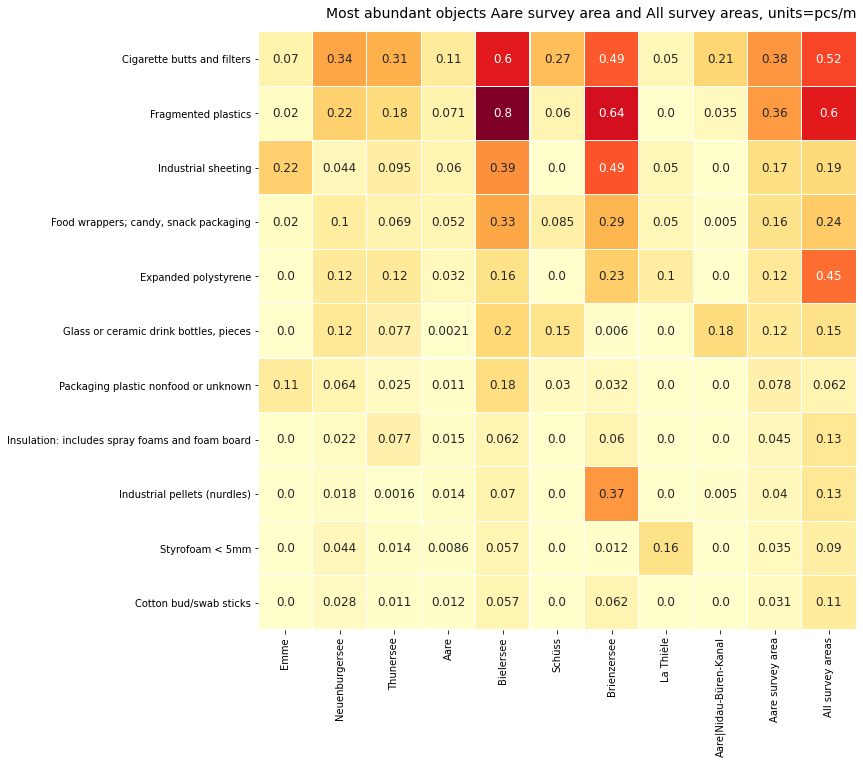

In [25]:
t_ten_all_data['item'] = t_ten_all_data.index.map(lambda x: code_description_map[x])
ad_t_ten = t_ten_all_data.set_index('item', drop=True)
ad_t_ten.sort_values(by=level_names[0], ascending=False, inplace=True)

# chart that
fig = plt.figure(figsize=(11,11))
gs = GridSpec(12, 3, figure=fig,  width_ratios=[.45,.1,.45])

axone = fig.add_subplot(gs[:, :])

sns.heatmap(ad_t_ten, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.1, linecolor='white')
axone.set_title(F"Most abundant objects {level_names[-2]} and {level_names[-1]}, units=pcs/m", **ck.title_k14r)
axone.set_ylabel("")

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

[top](#top)<a id='frequency'></a>
### How often are these objects found?

Some objects are found often and in elevated quantities, others are found often and in small quantities and some objects are found less often but in large quantities. Knowing the diffference can help find the sources.

#### The number of surveys where at least one of the most abundant objects were found

**Note** The survey area results include the results from the current water feature

In [26]:
l = top_feature_data[(top_feature_data.code.isin(a_combined_t_ten))].groupby('code', as_index=False).fail.sum()
l['tries'] = l.code.map(lambda x: top_feature_data[top_feature_data.code == x].loc_date.nunique())
l['fail_rate'] = l.fail/l.tries
l['Item'] = l.code.map(lambda x: code_description_map[x])

fl = fd[(fd.code.isin(a_combined_t_ten))].groupby('code', as_index=False).fail.sum()
fl['tries'] = fl.code.map(lambda x: fd[fd.code == x].loc_date.nunique())
fl['fail_rate'] = fl.fail/fl.tries
fl['Item'] = fl.code.map(lambda x: code_description_map[x])

def make_vals_strings(x,xone):
    return()
fl[level_names[0]] = fl.apply(lambda row: '{} / {} or {:.1%}'.format(row.fail, row.tries, row.fail_rate), axis=1)
l[level_names[1]] = l.apply(lambda row: '{} / {} or {:.1%}'.format(row.fail, row.tries, row.fail_rate), axis=1)
combined_fail_rates = pd.merge(fl[['Item', level_names[0]]],l[['Item', level_names[1]]], on='Item')

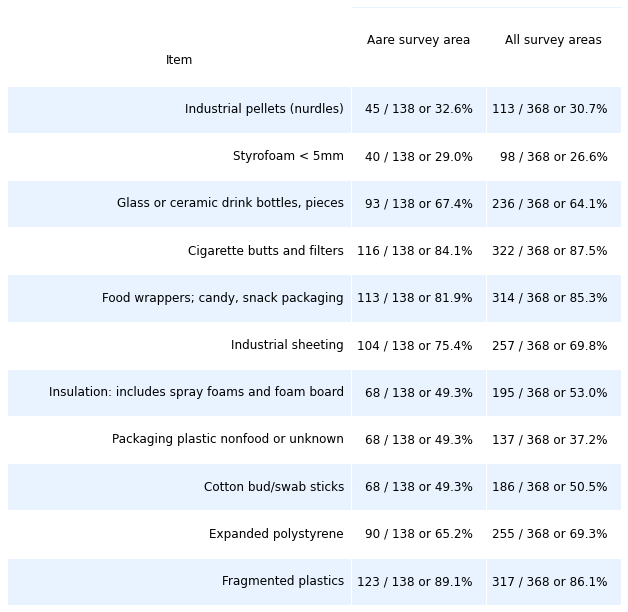

In [27]:
width = 11
a_color='dodgerblue'

fig, ax = plt.subplots(figsize=(width,len(combined_fail_rates)*1))
hide_spines_ticks_grids(ax)

the_first_table_data = ax.table(combined_fail_rates[['Item', level_names[0], level_names[1]]].to_numpy(),  colLabels=['Item', level_names[0], level_names[1]], colWidths=[.56, .22,.22],bbox=[0,0,1,1])

a_summary_table_one = make_a_summary_table(the_first_table_data,combined_fail_rates,['Item', level_names[0], level_names[1]] , a_color, s_et_bottom_row=False)

banded_color= colors.to_rgba(a_color)
banded_color= (*banded_color[:-1], 0.1)

for a_cell in a_summary_table_one.get_celld():    
        
        this_cell = a_summary_table_one.get_celld()[a_cell]       
        
        try:           
            a_val = float(this_cell._text.get_text())
            if a_val > 0:
                this_cell.set_facecolor(banded_color)
                this_cell.get_text().set_text(' + ')
                this_cell.set_text_props(ha='center')
            elif a_val < 0:
                this_cell.set_facecolor(banded_color)
                this_cell.get_text().set_text(' - ')
                this_cell.set_text_props(ha='center')
            elif a_val == 0:
                this_cell.set_facecolor('white')
                this_cell.get_text().set_text('NA')
                this_cell.set_text_props(ha='center')
            else:
                this_cell.set_facecolor('black')
        except:
            pass

plt.show()
plt.tight_layout()
plt.close()

[top](#top)
<a id='matanduse'></a>
### Utility: percent of total objects collected

The utility type is based on the utilisation of the object prior to it being discarded. Objects that are found are placed into to one of the 260 categories. Those categories are grouped according to utilisation.

For example, a piece of plastic could be placed into the category 'Fragmented plastics', depending on its size. However, a piece of plastic that was once a bucket
and we know this because we are familiar with either the brand or the product or if we recognize it as a piece of a bucket it is placed in the code for buckets⁸.

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastic items and pre-production plastic resins
*  **infrastructure**: items related to construction and maintenance of all infratructure items 
*  **food and drink**: primarily single use plastic items related to consuming food and drinks outdoors  
*  **agriculture**: primarily industrial sheeting includes mulch films
*  **tobacco**: primarily cigarette ends includes all smoking related material 
*  **recreation**: includes fishing, hunting, boating and beach related objects, excludes food, drink and tobacco items   
*  **packaging non food and drink**: packaging or wrapping material not identified as food, drink nor tobacco related  
*  **plastic fragments**: foam and plastic fragments of indeterminate origin and use 
*  **personal items**: accessories, hygiene and clothing related 

<span style="font-size:10">⁸ See the annex for the complete list of objects identified, includes category and group classification - the code for a buckets is G57</span>

In [28]:
these_kwargs = dict(
    group='groupname',
    dailycols={'pcs_m':'sum', 'quantity':'sum'}, 
    agg_cols={"quantity":"sum"},
    national=True,
    col_name="All survey areas",
    level_names=names_for_cols,
    bassin_summary=True,
    daily=True,
    feature_component=feature_component,
    feature_level=feature_level
)

code_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, features_and_levels, **these_kwargs)
code_groups_pcs_m.sort_values(by=level_names[0], ascending=False, inplace=True)

In [29]:
# get the total object count for each water feature
feature_component_denoms = {x:dims_summary_stats.loc[x, 'pieces of trash'] for x in feature_names}
feature_level_denom = {level_names[0]:dims_stats['pieces of trash']}
feature_top_denom = {level_names[1]:tp_ct.quantity.sum()}
feature_all = {"All survey areas":ct_all_data.quantity.sum()}

feature_denominators = {**feature_component_denoms, **feature_level_denom, **feature_top_denom, **feature_all}

# apply denominaotrs to code_group_pcs_m
column_denominators = [feature_denominators[x] for x in code_groups_pcs_m.columns]

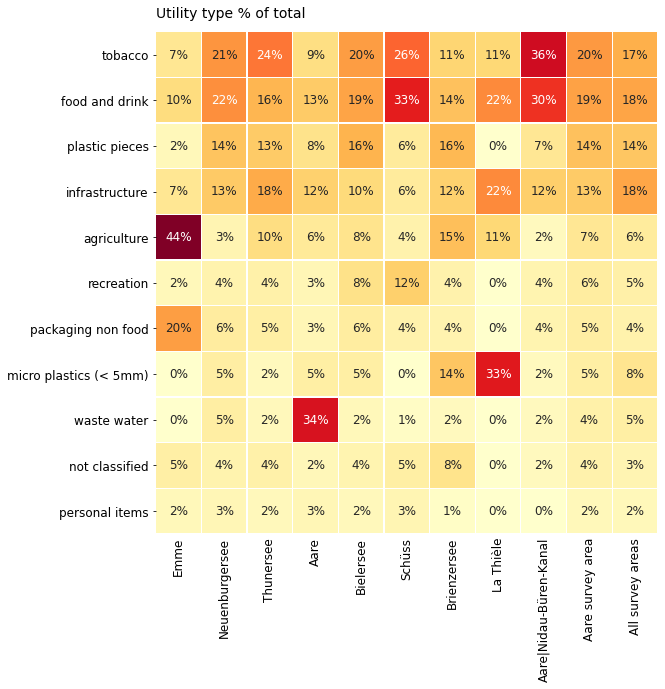

In [30]:
# divide each column by the column denominators
cgroup_p_t = code_groups_pcs_m.divide(column_denominators).round(3)
# cgroup_p_t.rename(columns={x:location_wname_key.loc[x] for x in feature_names}, inplace=True)

fig = plt.figure(figsize=(9,9))

gs = GridSpec(12, 1, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[1])

axone = fig.add_subplot(gs[:,:])
sns.heatmap(cgroup_p_t , ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, cbar=False, linewidth=.1, fmt='.0%', square=True, linecolor='white')
axone.set_title("Utility type % of total", **ck.title_k14)
axone.tick_params(**ck.no_xticks)
axone.set_ylabel("")

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=12)
plt.show()

### More information

Contact hammerdirt.ch for any questions about the content of this report. If you would like a report for your municipality contact the Swiss federal office for the environment: Municipal waste section.

In [31]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
md(F"""### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*{author}* pushed the run button on {today}.
""")

### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*roger@hammerdirt.ch* pushed the run button on 2021-05-25.


[top](#top)<a id="annex"></a>
### Annex

1. [Effective data](#data)
2. [Correlation of results](#popinf)
3. [Survey location GPS](#gps)
4. [Inventory of all objects removed](#inventory)

### Effective data

The data is submitted in two parts. If a survey is missing either part we check the paper records and update when possible.[top](#top)<a id="annex"></a>

In [32]:
if len(no_qty) > 0:
    a_new_string = ', '.join([str(x) for x in no_qty.loc_date.unique()])    
    no_surveys = F"These dimensional records have been dropped, there is no matching survey data:\n\n{a_new_string}.\n"
else:
    no_surveys = "\nAll dimensional records found a home in the survey data!"

if len(no_matching_dim_records) > 0:
    no_dims = ', '.join([str(x) for x in no_dim_locdate])
    no_dimensions = F"\n<span style='color:#008891'>These are the surveys that do not have matching dimensional data</span>:\n\n{no_dims}\n"
    per_cent_surveys = F"\n! THE DIMENSIONAL DATA SUMMARY IS CALCULATED USING {np.round(((1-len(no_dim_locdate)/len(ldu))*100),1)}% of the survey data !"
    requests = "\nRequests have been made to surveyors to submit the missing records.\n"
    dimensional_data = F"{no_dimensions}{per_cent_surveys}{no_surveys}{requests}"
else:
    has_dimensions = "All the surveys found a home in the dimensional data"
    dimensional_data = F"""{has_dimensions}<br><br>{no_surveys}
"""

md(dimensional_data)

All the surveys found a home in the dimensional data<br><br>
All dimensional records found a home in the survey data!


<a id="popinf"></a>

### Correlation of results to local conditions

The survey results for the most abundant objects were ranked against **population** and three other criteria for each survey location. **Within a radius of 1500m of each survey location** the following characteristics were calculated: 

*  buildings: m² of surface area attributed to buildings

*  streets: length in meters of all roads

*  number of stream/river discharge points

The three attributes were evaluated seperately and combined - *urbanization*. Urbanization is the weighted value of the sum of population, buildings and streets for each survey. The values were evaluated using the Spearmans rank correlation with p= 0.1. The results can be interpreted in the following way:

*  " + " - positive correlation: the chances of finding the object and the quantity found were increased as the amount of the attrubute increased within 1500m the survey area.

*  " - " - negative correlation: neither the chances or the quantity of finding the object found were increased by this attribute, and previously it was found in greater quantities when this atribute was minimized within 1500m of the survey area.

*  " NA " - no effect: there is no statistical basis to reject a null effect by this attribute based on the current results.

**Important!** Results vary for each location and at each survey. A correlation is not a sign of causation.<a id="popinf"></a>

In [33]:
to_geo_data_dt = fd.groupby(['loc_date','location'], as_index=False).pcs_m.sum()
tg_data_dt = to_geo_data_dt.groupby('location').pcs_m.median()

to_geo_data_tndt = fd[fd.code.isin(a_combined_t_ten)].groupby(['loc_date', 'location'], as_index=False).pcs_m.sum()
tg_data_dttn = to_geo_data_tndt.groupby('location').pcs_m.median()

tg_beaches = dfBeaches[dfBeaches.index.isin(fd_locs)].copy()
tg_beaches['pcs_m'] = tg_beaches.index.map(lambda x: tg_data_dt[x])
tg_beaches['t_pcs_m'] = tg_beaches.index.map(lambda x: tg_data_dttn[x])
tg_beaches.to_csv(F"{project_directory}/bassin_summary_beaches.csv", index=False)

In [34]:
hmmx = fd.groupby(['loc_date','location', 'code', 'population', 'buildings', 'streets', 'intersects'], as_index=False).pcs_m.sum()
hmmx ['urbanization'] = ((hmmx.population + hmmx.streets + hmmx.buildings)/(hmmx.population.unique().sum() + hmmx.streets.unique().sum() + hmmx.buildings.unique().sum()))
a_codes = list(set(a_combined_t_ten))
thevs = ['pcs_m','population', 'buildings', 'streets', 'urbanization', 'intersects']
spmns = []


for code in a_codes:
    data = hmmx[hmmx.code == code][thevs].to_numpy()
    spearmans_r = stats.spearmanr(data)
    spmns.append({code:(spearmans_r[0][0]/abs(spearmans_r[0][0]))*spearmans_r[1][0]})
rnull = {}
for result in spmns:
    for k,v in result.items():
        reject_null = {k:{thevs[1:][i]:x for i,x in enumerate(v[1:]) if abs(x) <= 0.1}}
        rnull.update(reject_null)

# spearmans rank correlation for the most abundant obects
corr_tables = pd.DataFrame(rnull).fillna(0).T
corr_tables['Item'] = corr_tables.index.map(lambda x: code_description_map[x])
corr_tables.set_index('Item', drop=True, inplace=True)
corr_tables.reset_index(inplace=True)


# flip it for display

def color_choice(x):
    if type(x) == str:
        data = x
    elif x > 0:
        data = 1
    elif x < 0:
        data = -1
    else:
        data = x
    return data
corr_tables = corr_tables[['Item','population', 'buildings', 'streets', 'urbanization', 'intersects']]
f_or_display = corr_tables.applymap(lambda x: color_choice(x))


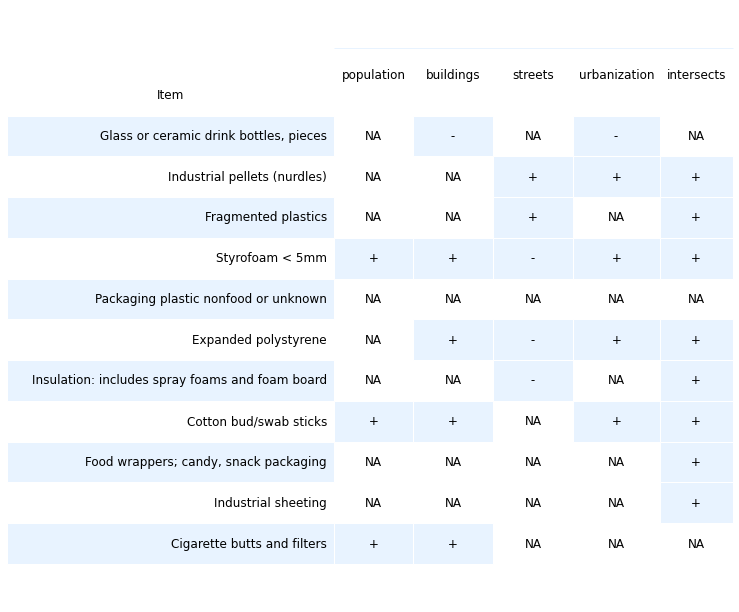

In [35]:
width = 13
a_color='dodgerblue'

fig, ax = plt.subplots(figsize=(width,len(corr_tables)*1))
hide_spines_ticks_grids(ax)

the_first_table_data = ax.table(f_or_display.to_numpy(),  colLabels=list(corr_tables.columns), colWidths=[.45, .11,.11, .11, .12, .1],loc='center')

a_summary_table_one = make_a_summary_table(the_first_table_data,f_or_display,list(corr_tables.columns), 'dodgerblue', s_et_bottom_row=False)

banded_color= colors.to_rgba(a_color)
banded_color= (*banded_color[:-1], 0.1)

for a_cell in a_summary_table_one.get_celld():    
        
        this_cell = a_summary_table_one.get_celld()[a_cell]       
        
        try:           
            a_val = float(this_cell._text.get_text())
            if a_val > 0:
                this_cell.set_facecolor(banded_color)
                this_cell.get_text().set_text(' + ')
                this_cell.set_text_props(ha='center')
            elif a_val < 0:
                this_cell.set_facecolor(banded_color)
                this_cell.get_text().set_text(' - ')
                this_cell.set_text_props(ha='center')
            elif a_val == 0:
                this_cell.set_facecolor('white')
                this_cell.get_text().set_text('NA')
                this_cell.set_text_props(ha='center')
            else:
                this_cell.set_facecolor('black')
        except:
            pass

plt.show()
plt.tight_layout()
plt.close()

[Annex](#annex)<a id='gps'></a>

### Survey locations

In [36]:
# rb_beaches_list = dfBeaches[dfBeaches.index.isin(rb_locs)][['location', 'latitude', 'longitude', 'city', 'water_name']].copy()
tg_beaches.set_index('location', inplace=True, drop=True)
tg_beaches[['city', 'bfsnum', 'water_name',  'latitude', 'longitude']].sort_values(by='water_name')

city  bfsnum  \
location                                                   
Aare Limmatspitz                      Gebenstorf    4029   
Oberi Chlihöchstetten                    Rubigen     623   
Späckmatt                              Luterbach    2527   
Mannewil                                Kallnach     304   
Bern Tiergarten                             Bern     351   
Bern Fahrstrasse                            Bern     351   
aare_suhrespitz_badert                     Aarau    4001   
Beich                                 Walperswil     754   
aare_köniz_hoppej                          Köniz     355   
Aare_Brugg_BuchiE                          Brugg    4095   
aare_bern_scheurerk                         Bern     351   
Aare_bern_gerberm                           Bern     351   
Aare Solothurn Lido Strand             Solothurn    2601   
Gummligrabbe                            Kallnach     304   
Brügg BE Büren BSG Standort                Brügg     733   
Aare_post                                   Port     745   
Lüscherz two                            Lüscherz     497   
Nidau strand                               Nidau     743   
Müllermatte                          Biel/Bienne     371   
Bielersee_Vinelz_FankhauserS              Vinelz     502   
Camp des pêches                      Le Landeron    6455   
Lüscherz plage                          Lüscherz     497   
Strandboden-Biel                     Biel/Bienne     371   
Gals reserve                                Gals     494   
Ligerz strand                             Ligerz     740   
Oben am see                          Brienz (BE)     573   
Wycheley                             Brienz (BE)     573   
Häfeli                                   Bönigen     572   
Schútzenmatte                           Burgdorf     404   
La Thièle_Le Mujon_confluence  Yverdon-les-Bains    5938   
Signalpain                     Yverdon-les-Bains    5938   
Ruisseau de la croix plage       Cheyres-Châbles    2055   
Plage de Serrière                      Neuchâtel    6458   
Plage de Cheyres                 Cheyres-Châbles    2055   
La Petite plage                Yverdon-les-Bains    5938   
Evole plage                            Neuchâtel    6458   
Nouvelle plage                         Estavayer    2054   
Hauterive Petite plage            Hauterive (NE)    6454   
Impromptu_Cudrefin                      Cudrefin    5456   
Pécos Plage                             Grandson    5561   
Pointe d'Areuse                           Boudry    6404   
Schüsspark strand                    Biel/Bienne     371   
Delta park                                 Spiez     768   
Weissenau-Neuhaus                      Unterseen     593   
Camping Gwatt Strand                        Thun     942   
AugustMützenbergStrandweg                  Spiez     768   
Sundbach strand                       Beatenberg     571   
Thun Strandbad                              Thun     942   
thunersee_spiez_meierd_1                   Spiez     768   

                                           water_name   latitude  longitude  
location                                                                     
Aare Limmatspitz                                 Aare  47.501060   8.237371  
Oberi Chlihöchstetten                            Aare  46.896025   7.532114  
Späckmatt                                        Aare  47.223749   7.576711  
Mannewil                                         Aare  46.996382   7.239024  
Bern Tiergarten                                  Aare  46.933157   7.452004  
Bern Fahrstrasse                                 Aare  46.975866   7.444210  
aare_suhrespitz_badert                           Aare  47.405669   8.066018  
Beich                                            Aare  47.048495   7.200528  
aare_köniz_hoppej                                Aare  46.934589   7.458170  
Aare_Brugg_BuchiE                                Aare  47.494855   8.236558  
aare_bern_scheurerk                            

[Annex](#annex)<a id="inventory" ></a>
#### Inventory of all items

In [37]:
fd_code_t['utility'] = fd_code_t.index.map(lambda x: utility_map.loc[x, 'groupname'])
fd_code_t['item'] = fd_code_t.index.map(lambda x: code_description_map.loc[x])
fd_code_t["% of total"] = (fd_code_t["% of total"]*100).round(1)
fd_code_t["% of samples"] = ((fd_code_t["fail"]/len(fd.loc_date.unique()))*100).round(1)
complete_inventory = fd_code_t[['item', 'quantity', '% of total', 'utility', '% of samples']]

In [38]:
pd.set_option('display.max_rows', None)
complete_inventory[complete_inventory.quantity > 0].sort_values(by='quantity', ascending=False)

item  quantity  \
code                                                                  
G27                           Cigarette butts and filters      2562   
Gfrags                                Fragmented plastics      1986   
G30                 Food wrappers; candy, snack packaging       913   
Gfoam                                Expanded polystyrene       846   
G67                                   Industrial sheeting       828   
G200               Glass or ceramic drink bottles, pieces       686   
G941                 Packaging plastic nonfood or unknown       441   
G74       Insulation: includes spray foams and foam board       297   
G117                                      Styrofoam < 5mm       294   
G112                         Industrial pellets (nurdles)       258   
G98                                       Diapers - wipes       257   
G89                            Plastic construction waste       224   
G177                         Foil wrappers, aluminum foil       200   
G95                                Cotton bud/swab sticks       196   
G25               Tobacco; plastic  packaging, containers       161   
G904    Fireworks; rocket caps, exploded parts & packa...       150   
G156                                      Paper fragments       149   
G178        Metal bottle caps, lids & pull tabs from cans       117   
G213                                         Paraffin wax       109   
G106                       Plastic fragments angular <5mm       105   
G940                     Foamed EVA for crafts and sports       102   
G50                                          String < 1cm        98   
G21                                            Drink lids        96   
G23                                     Lids unidentified        92   
G33        Cups, lids, single use foamed and hard plastic        87   
G922                                    Labels, bar codes        86   
G35                                   Straws and stirrers        85   
G186                                     Industrial scrap        82   
G24         Lid/cap rings from plastic bottles/containers        80   
G211    Other medical items (swabs, bandaging, adhesiv...        73   
G31                                       Lollypop sticks        71   
G10          Food containers single use foamed or plastic        71   
G32                                 Toys and party favors        69   
G923          Tissue, toilet paper, napkins, paper towels        60   
G73     Foamed items & pieces (non packaging/insulatio...        58   
G66         Straps/bands;  hard, plastic package fastener        56   
G153              Cups, food containers, wrappers (paper)        52   
G203     Tableware ceramic or glass, cups, plates, pieces        49   
G22             Lids for chemicals, detergents (non-food)        49   
G936                         Sheeting ag. greenhouse film        48   
G908                         Tape; electrical, insulating        46   
G93                  Cable ties; steggel, zip, zap straps        45   
G204         Construction material; bricks, pipes, cement        45   
G152     Cigarette boxes, tobacco related paper/cardboard        43   
G87                            Tape, masking/duct/packing        43   
G191                                        Wire and mesh        43   
G3      Bags; plastic shopping/carrier/grocery and pieces        42   
G96                    Sanitary-pads/panty liners/tampons        41   
G100                 Medical; containers/tubes/ packaging        40   
G125                          Balloons and balloon sticks        40   
G91                                        Biomass holder        37   
G137                              Clothing, towels & rags        35   
G944                   Pellet mass from injection molding        34   
G905    Hair clip,  hair ties, personal accessories pl...        33   
G175                                       Cans, beverage        31   
G70   